# Analyze A/B Test Results 
The current notebook is organised into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

Let's import the necessary libraries.


In [99]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline
random.seed(42)

In [2]:
# Reading data from a csv file into a dataframe
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
df.query('landing_page != "new_page" and group == "treatment"').shape[0]

1965

In [7]:
df.query('landing_page != "old_page" and group == "control"').shape[0]

1928

**f.** Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


There are no missing values as the total number of entries are equal to the count of non-null values in all columns

In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df[(df['group'] == 'control') & (df['landing_page'] == 'old_page') | (df['group'] == 'treatment') & (df['landing_page'] == 'new_page')]
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
df2.describe()

,user_id,converted
count,290585.000000,290585.000000
mean,788004.825246,0.119597
std,91224.582639,0.324490
min,630000.000000,0.000000
25%,709035.000000,0.000000
50%,787995.000000,0.000000
75%,866956.000000,0.000000
max,945999.000000,1.000000


In [11]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**a.** How many unique **user_id**s are in **df2**?

In [12]:
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [13]:
sum(df2.user_id.duplicated())

1

**c.** Display the rows for the duplicate **user_id**? 

In [14]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [15]:
# Remove one of the rows with a duplicate user_id..
df2 = df2[~df2.user_id.duplicated(keep='first')]

In [16]:
df2.shape[0]

290584


**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>
 <center>
 $p_{population}$
</center>


In [17]:
p_pop=df2['converted'].mean()
p_pop

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
control_mean = df2.query('group == "control"')['converted'].mean()
control_mean

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
treatment_mean = df2.query('group == "treatment"')['converted'].mean()
treatment_mean

0.11880806551510564

In [20]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treatment_mean - control_mean
obs_diff


-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [21]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

**e.** Consider the results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

From the above calculation of probabilities, we observe that the probability of conversion is more in the control group i.e. with the old webpage than with the new one.However, we need to check if the result is statistically significant or is it by chance.

<a id='ab_test'></a>
## Part II - A/B Test

In order to test the above result, we will assume that the old page is better unless the new page proves to be definitely better.Hence that becomes our null hypothesis as null hypothesis is what we assume to be true before analysing.The null and alternative hypothesis will look as under in this case:

<center>
$H_0$ : $p_{new}$ <= $p_{old}$
</center>
<center>
$H_1$ : $p_{new}$ > $p_{old}$ @ 𝛼=0.05
</center>


### Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [22]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [23]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [24]:
size_new = df2.query('landing_page == "new_page"').shape[0]
size_treatment = df2.query('group == "treatment"').shape[0]
size_new, size_treatment

(145310, 145310)

**d.** What is $n_{old}$, the number of individuals in the control group?

In [25]:
size_old = df2.query('landing_page == "old_page"').shape[0]
size_control = df2.query('group == "control"').shape[0]
size_old,size_control

(145274, 145274)

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [26]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1,0], size_new, replace=True, p = [p_new,1-p_new])
new_page_converted

array([0, 0, 0, ..., 0, 1, 0])

Calculating "converted" probability  $(p{'}_{new})$ for `treatment` group

In [100]:
p_new2 = np.mean(new_page_converted)
p_new2

0.11975087743445048

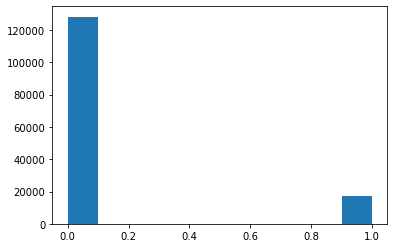

In [28]:
plt.hist(new_page_converted);

**f. Simulate Sample for the `control` Group** <br>
Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br>

In [29]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1,0], size_old, replace=True, p = [p_old,1-p_old])
old_page_converted

array([0, 0, 1, ..., 0, 1, 0])

Calculating "converted" probability  $(p{'}_{old})$ for `control` group

In [101]:
p_old2 = np.mean(old_page_converted)
p_old2

0.11923675261918856

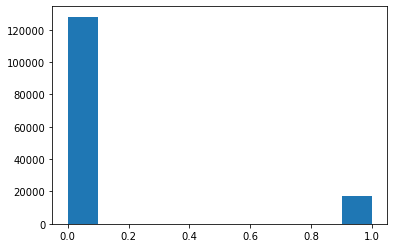

In [31]:
plt.hist(old_page_converted);

**g.** Now, we find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for our simulated samples from the parts (e) and (f) above. 

In [32]:
np.mean(new_page_converted) - np.mean(old_page_converted)

-0.0012268388621858306


**h. Sampling distribution** <br>
Re-creating `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process used in parts (a) through (g) above. 

<br>
Storing all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [33]:
# Sampling distribution 
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([1,0], size_new, replace=True, p = [p_new,1-p_new])
    old_page_converted = np.random.choice([1,0], size_old, replace=True, p = [p_old,1-p_old])
    p_diffs.append(np.mean(new_page_converted) - np.mean(old_page_converted)) 
    

**i. Histogram**<br> 
Plotting a histogram of the **p_diffs**.  

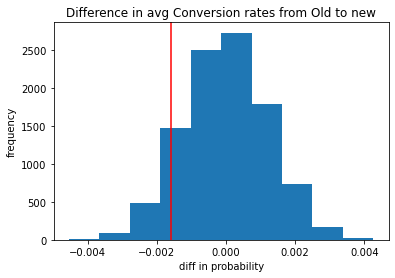

In [34]:
plt.hist(p_diffs);
plt.xlabel('diff in probability');
plt.ylabel('frequency');
pylab.title('Difference in avg Conversion rates from Old to new');
plt.axvline(x=obs_diff, color = 'r')

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [35]:
#Calculating p-value

(p_diffs > obs_diff).mean()

0.9022

**k.** explaination in words what we have just computed in part **j** above.  

The value calculated above is called p-value which is 0.9022 and is greater than the type I error rate(alpha) of 0.05.Since, p-value is greater than alpha, we fail to reject the null hypothesis.Hence, our assumption i.e. old_webpage leads to more or equal conversions is true.We further test this hypothesis using z-score in the next section.

<span style="color: purple;">However, using for loops is computationally very expensive as this is only basic python functionality, and that when possible a binomial distribution is preferred over bootstrapping, as a lightweight methodology.Hence, it is better to use specifically designed libraries which are built in low-level languages and help in writing more efficient and stable code.In this case, we shall use numpy which is 100 times faster than standard python calculation.We will deploy the following method:
</span>


**l. Using Built-in Methods for Hypothesis Testing**<br>

In [102]:
p_diffs = []
new_converted_simulation = np.random.binomial(size_new,p_new2,10000)/size_new
old_converted_simulation = np.random.binomial(size_old,p_old2,10000)/size_old
p_diffs = new_converted_simulation - old_converted_simulation

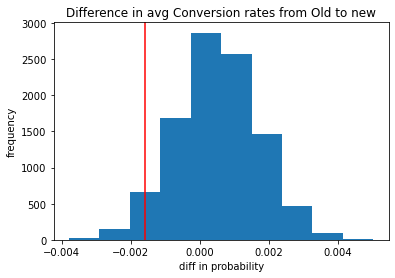

In [104]:
# Plotting a histogram

plt.hist(p_diffs);
plt.xlabel('diff in probability');
plt.ylabel('frequency');
pylab.title('Difference in avg Conversion rates from Old to new');
plt.axvline(x=obs_diff, color = 'r')

In [105]:
#Calculating p-value
(p_diffs > obs_diff).mean()

0.9608

In [37]:
# !pip install statsmodels

  Using cached statsmodels-0.14.0-cp39-cp39-macosx_10_9_x86_64.whl (9.9 MB)


In [50]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page"')['converted'].sum()

# number of conversions with the new_page
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()

# number of individuals who were shown the old_page
n_old = len(df2.query('landing_page == "old_page"'))

# number of individuals who received new_page
n_new = len(df2.query('landing_page == "new_page"'))

In [55]:
print("No. of conversions with old page:",convert_old)
print("No. of conversions with new page:",convert_new)
print("No. of individuals who are shown old page", n_old)
print("No. of individuals who are shown new page", n_new)

No. of conversions with old page: 17489
No. of conversions with new page: 17264
No. of individuals who are shown old page 145274
No. of individuals who are shown new page 145310


**m.** Now using `sm.stats.proportions_ztest()` to compute test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.
 
### About the two-sample z-test
We have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for our two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. We can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. We can determine the $Z_{\alpha}$ from the z-table manually. 

Our hypothesis is a right-tailed test. Accordingly, we reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected if the $Z_{score}$ lies in that region.

><br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 

Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

In [56]:
import statsmodels.api as sm
# from statsmodels.stats.proportion import proportions_ztest

z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old],alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

In a right-tailed test, we reject the null if $Z_{score}$ > $Z_{0.05}$.
However, since $Z_{score}$ < $Z_{0.05}$, we fail to reject the null.
Also, If the p-value that corresponds to the z test statistic is less than the chosen significance level, then we can reject the null(https://www.statology.org/two-sample-z-test/)
However, the p-value is greater than the chosen significance level of 0.05, hence we fail to reject the null.

Based on the z-test results, there is not enough evidence to suggest that there is a significant difference in the number of conversions between the old page and the new page.


<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should we be performing in this case?

Regression is a statistical method used in finance, investing, and other disciplines that attempts to determine the strength and character of the relationship between one dependent variable (usually denoted by Y) and a series of other variables (known as independent variables or explanantory variable).
For this data, we will use Logistic Regression as both the explanatory and response variables are categorical in nature  - 
1. Response Variable(Y) - converted
2. Explanatory Variable(x) - landing_page or group

and our hypothesis would be:
<center>
$H_0$ : $p_{new}$ - $p_{old}$ = 0
</center>
<center>
$H_1$ : $p_{new}$ - $p_{old}$ != 0 (two-sided)
</center>


**b.** The goal is to use **statsmodels** library to fit the regression model specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, we first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [57]:
df2['intercept'] = 1

In [65]:
df2['ab_page'] = pd.get_dummies(df['group'])['treatment'].astype(int)

In [66]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate our regression model on the two columns we created in part (b). above, then fit the model to predict whether or not an individual converts. 


Since, both the explanatory and response variables are categorical in nature, we will be using Logistic Regression Model.

In [70]:
logit_mod = sm.Logit(df2['converted'], df2[['ab_page','intercept']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Method:           MLE        
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-05-18 17:18 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           LLR p-value:      0.18988    
No. Iterations:     6.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
==================================================================

"""

**d.** Providing the summary of our model below, and using it as necessary to answer the following questions.

In [71]:
# EXPONENTIATE THE COEFFICIENT for ab page
np.exp(-0.0150)


0.9851119396030626

**Coefficients** : The odds of conversion for the new page are 0.985 times the odds of conversion for the old page, holding all other variables constant.This means that the odds of conversion for the new page are slightly lower than the odds of conversion for the old page. However, this difference is quite small and may not be practically significant.

**P-value** : 0.1899. The p-value is greater than 0.05, which means we fail to reject the null hypothesis. This suggests that there is not enough evidence to conclude that the new page has a significantly different conversion rate compared to the old page.

**Confidence Intervals** : This means that we are 95% confident that the true population coefficient for ab_page lies within range(-0.0374 - 0.0074). Since the confidence interval includes 0, it indicates that there is a possibility that there is no effect of the new page on the conversion rate. This further supports the finding from the p-value that there is not enough evidence to conclude that the new page has a significantly different conversion rate compared to the old page.

**R-squared** : There could be several reasons for a pseudo R-squared value of 0:

**a**. The explanatory variables included in the model might not have any relationship with the outcome variable.

**b**. There might be important variables missing from the model that could help explain the variance in the outcome variable.

**c**. The relationship between the explanatory variables and the outcome variable might be more complex than what can be captured by a logistic regression model (e.g., non-linear relationships or interactions between variables)

Based on these results, we must either consider running the experiment for a longer duration, collecting more data, or exploring other factors(more exploratory variables) that could potentially influence the conversion rate.
Investigate potential interactions between the explanatory variables.

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value found in **Part II**?<br><br>  

***Answer*** - P-value : 0.1899. The p-value is greater than 0.05, which means we fail to reject the null hypothesis. This suggests that there is not enough evidence to conclude that the new page has a significantly different conversion rate compared to the old page.

the p-values from a two-sample z-test and logistic regression are different because they are testing different hypotheses and are based on different statistical models. The two-sample z-test is used to compare the means of two independent groups, while logistic regression is used to predict the probability of a binary outcome based on one or more predictor variables.

The null hypothesis and alternative hypothesis for two sample z test are : 
<center>
$H_0$ : $p_{new}$ <= $p_{old}$
</center>
<center>
$H_1$ : $p_{new}$ > $p_{old}$ @ 𝛼=0.05 (one-sided)
</center>
  
The null and alternative hypothesis for Logistic regression model are as under:
<center>
$H_0$ : $p_{new}$ - $p_{old}$ = 0
</center>
<center>
$H_1$ : $p_{new}$ - $p_{old}$ != 0 (two-sided)
</center>

<span style="color: blue;">The difference is p-value is because we are using a one-sided test in two sample z test as opposed to a two-sided test in Regression model.</span>
When we calculate p-value in two sample z two-sided test, we get p-value of 0.1899 as calculated below(which is same as that calculated using regression model)

In [107]:
z_score1, p_value1 = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old])
print(z_score1, p_value1)

-1.3109241984234394 0.18988337448195103


**f.** Now, we are considering other things that might influence whether or not an individual converts.Lets discuss Why it is a good idea to consider other factors to add into our regression model.  Are there any disadvantages to adding additional terms into our regression model?

***Answer*** Adding additional terms to the regression model can provide more insights and improve the model's predictive power. However, there are some potential disadvantages to consider:

***Overfitting***: Adding too many terms to the model can lead to overfitting, where the model becomes too complex and captures the noise in the data rather than the underlying pattern. This can result in poor generalization to new, unseen data.

***Multicollinearity***: When adding new terms, there is a risk of multicollinearity, which occurs when two or more predictor variables are highly correlated. This can lead to unstable estimates of the regression coefficients and make it difficult to interpret the individual effects of each predictor variable.

***Interpretability***: As more terms are added to the model, it becomes more complex and harder to interpret. This can make it challenging to communicate the results to non-technical stakeholders or to understand the practical implications of the model.

***Computational complexity***: Adding more terms increases the computational complexity of the model, which can slow down the training process and require more computational resources.

***Diminishing returns***: In some cases, adding more terms may not lead to a significant improvement in the model's performance. This can result in wasted effort and resources spent on collecting and processing additional data.

To mitigate these disadvantages, it is essential to carefully select the predictor variables based on domain knowledge, statistical tests, and feature selection techniques. Regularization methods, such as Lasso or Ridge regression, can also be used to penalize overly complex models and reduce the risk of overfitting.

**g. Adding countries**<br> 

2. Does it appear that country had an impact on conversion?  

In [97]:
# Read the countries.csv
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [76]:
df_countries.dtypes

user_id     int64
country    object
dtype: object

In [77]:
df2.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
intercept        int64
ab_page          int64
dtype: object

In [81]:
# Join with the df2 dataframe
df_merged = pd.merge(df_countries, df2, on="user_id")
df_merged.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [88]:
df_merged['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [90]:
# Create the necessary dummy variables
df_merged[['UK','US','CA']] = pd.get_dummies(df_merged['country']).astype(int)
df_merged.head()


,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,,UK,US,CA
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


In [98]:
# Fitting model, and summarizing the results
logit_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK','US']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Method:           MLE        
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-05-19 15:23 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           LLR p-value:      0.17599    
No. Iterations:     6.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
UK           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
US            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [95]:
np.exp(-0.0149), np.exp(-0.0408), np.exp(0.0099)

(0.9852104557227469, 0.9600211149716509, 1.0099491671175422)

This means that, holding all other variables constant, users on the new_page are 0.9852 times as likely to convert as users on the old_page. In other words, users on the new_page are slightly less likely to convert compared to users on the old_page.Since the p-value is 0.1912 (> 0.05), this effect is not statistically significant.


Also, holding all other variables constant, users in the UK are 0.9600 times as likely to convert as users in the baseline country (CA).In other words, users in the UK are slighltly less likely to convert compared to user in the CA.Since the p-value is 0.1295 (>0.05), this effect is not statistically significant.

Again, holding all other variables constant, users in the US are 1.0099 times as likely to convert as users in the baseline country(CA). In other words, users in the US are slightly more likely to convert compared to users in CA. since is p-value is 0.4573 (>0.05), this effect is not statistically significant.

Since, all results are statistically insignificant, it means that the explanatory variables(landing/-page,countries) in the model are not significantly related to the response variable(conversion). In other words, the model is not able to explain the variation in the response variable. 

In [116]:
df_merged.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,,UK,US,CA
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


**h. Fitting model**<br>  
We would now like to look at an interaction between page and country. Interaction is useful when slopes (coefficients) of X variables are not same and we need to check the effect of landing page on conversion depends on the country in which the user is accessing it.

In [109]:
df_new = df_merged.copy()

In [112]:
df_new['ab_UK'] = df_new['ab_page'] * df_new['UK']
df_new['ab_US'] = df_new['ab_page'] * df_new['US']

In [113]:
df_new.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,,UK,US,CA,ab_UK,ab_US
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0,1,0,0,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1,0,0
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1,0,0,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,0,1


In [117]:
# Fitting model, and summarizing the results
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK','US','ab_UK','ab_US']])
results1 = logit_mod.fit()
results1.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Method:           MLE        
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-05-20 23:16 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           LLR p-value:      0.19199    
No. Iterations:     6.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
US           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ab_UK        -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
ab_US         0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

Since,  p-values for all the interaction terms are greater than 0.05, it means that none of the interaction terms(ab_UK and ab_US) are statistically significant. This suggests that there is no significant difference in the effect of the new page on the conversion rate between users in the US, users in the UK, and users in Canada.

We may need to look into other factors which make a statistically and practically significant impact on the conversion rate.We could look at the time of the day or day of the week that users visit the website, or we could look at the source of the traffic (e.g. direct, organic search, paid search, social media, etc.). These features could potentially have an effect on the conversion rate and could be included in the model as additional predictors.


**Summarizing results**
The results from first three tests(probablity, A/B test using simulation, two sample z-test) suggest that users on the new page are slighly less likely to convert compared to users on the old page.

However, the regression model suggests that this effect is not statistically significant indicating that there is no significant relationship between the landing page and conversion rate.

Adding a new factor (country) to find out if that has any impact on the conversion rate is also resulting in statistically non significant outcomes.

Even after checking the interaction between landing page and country, we found that results are statistically insignificant.

We may explore more factors like the time of the day a user visits the website or the day of the week, which actually affect the conversion rate with the new web page.

***Recommendation***

However, based on the existing factors and their findings,it is recommended not to implement the new webpage as all tests have not shown an increase in conversion rate.We do not have enough evidence to support the hypothesis that implementing a new page leads to conversion of users.

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])